In [15]:
import os
from pathlib import Path


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import cdist



In [16]:
CUR_DIR = os.path.abspath('')

DATA_DIR = Path(CUR_DIR).parent / "data" / "millionsong"
FILE_PATH = DATA_DIR/'triplets_metadata_spotify.csv'
df = pd.read_csv(FILE_PATH, index_col = 0)

In [17]:
df.head()

,user,listening_count,song_name,release,artist_name,duration,artist_familiarity,artist_hotttnesss,year,shs_perf,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_date
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,Stronger,Graduation,Kanye West,311.84934,0.877214,1.082503,2007,-1,...,-7.933,0,0.176,0.00763,0.0,0.526,0.495,103.977,4.0,2011-05-24
1,9fba771d9731561eba47216f6fbfc0023d88641b,19,Stronger,Graduation,Kanye West,311.84934,0.877214,1.082503,2007,-1,...,-7.933,0,0.176,0.00763,0.0,0.526,0.495,103.977,4.0,2011-05-24
2,85952991b8e3ca5803a08b0b2f9c6d71abf9bb5b,1,Stronger,Graduation,Kanye West,311.84934,0.877214,1.082503,2007,-1,...,-7.933,0,0.176,0.00763,0.0,0.526,0.495,103.977,4.0,2011-05-24
3,537340ff896dea11328910013cfe759413e1eeb3,2,Stronger,Graduation,Kanye West,311.84934,0.877214,1.082503,2007,-1,...,-7.933,0,0.176,0.00763,0.0,0.526,0.495,103.977,4.0,2011-05-24
4,8fce200f3912e9608e3b1463cdb9c3529aab5c08,2,Stronger,Graduation,Kanye West,311.84934,0.877214,1.082503,2007,-1,...,-7.933,0,0.176,0.00763,0.0,0.526,0.495,103.977,4.0,2011-05-24


In [18]:
len(df)

4982520

In [19]:
## keep first occurence of a given song/artist instance to reduce redundant observations

df = df.drop_duplicates(subset = ['song_name', 'artist_name'], keep='first').reset_index()
print("Duplicates of song_name", df['song_name'].duplicated().sum())
print("Size of dataframe", len(df))
df

Duplicates of song_name 2390
Size of dataframe 27607


,index,user,listening_count,song_name,release,artist_name,duration,artist_familiarity,artist_hotttnesss,year,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_date
0,0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,Stronger,Graduation,Kanye West,311.84934,0.877214,1.082503,2007,...,-7.933,0,0.1760,0.007630,0.000000,0.526,0.495,103.977,4.0,2011-05-24
1,18315,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,Stacked Actors,There Is Nothing Left To Lose,Foo Fighters,256.46975,0.839275,0.550762,1999,...,-5.145,1,0.0500,0.002030,0.001020,0.234,0.670,134.898,4.0,1999-11-02
2,20077,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,Clarity,As/Is: Cleveland/Cincinnati_ OH - 8/03-8/04/04,John Mayer,548.88444,0.837948,0.787679,0,...,-3.551,1,0.0384,0.172000,0.032000,0.177,0.491,94.710,4.0,2003-09-09
3,22873,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,Gimme Stitches,There Is Nothing Left To Lose,Foo Fighters,222.19710,0.839275,0.550762,1999,...,-4.215,1,0.0685,0.001750,0.002860,0.263,0.532,111.850,4.0,1999-11-02
4,23610,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,Breakout,There Is Nothing Left To Lose,Foo Fighters,200.80281,0.839275,0.550762,1999,...,-4.212,0,0.0522,0.000052,0.002910,0.124,0.427,156.794,4.0,1999-11-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27602,4982515,3796a24e109961914e04fc82f05e727751eba723,1,Dime,20th Anniversary,Jerry Rivera,284.29016,0.650177,0.404963,2001,...,-9.949,1,0.0403,0.784000,0.000000,0.217,0.805,87.814,4.0,2016-08-12
27603,4982516,61457d4f6b5053031c358de46929960f3d32d782,1,The Long Conversation,The Way That It Was,Pierre de Reeder,184.65914,0.511732,0.344567,2008,...,-10.025,1,0.0273,0.826000,0.033700,0.369,0.219,97.379,4.0,2010-04-20
27604,4982517,61457d4f6b5053031c358de46929960f3d32d782,1,That's the Way That It Was,The Way That It Was,Pierre de Reeder,167.28771,0.511732,0.344567,2008,...,-5.848,1,0.0370,0.030500,0.000079,0.112,0.304,135.861,4.0,2010-04-20
27605,4982518,bd0c3b42396ea8a1225eba1ac8c398b940e1b060,3,I'll Close My Eyes,Runnin Wild,Mike Jones,265.79546,0.793605,0.426318,0,...,-24.078,1,0.0350,0.982000,0.899000,0.839,0.247,69.497,4.0,1994


## Songs features selection

In [20]:
df.columns

Index(['index', 'user', 'listening_count', 'song_name', 'release',
       'artist_name', 'duration', 'artist_familiarity', 'artist_hotttnesss',
       'year', 'shs_perf', 'shs_work', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'release_date'],
      dtype='object')

In [21]:
tracks_feats = df.drop(['user', 'listening_count'],axis = 1).drop_duplicates()
len(tracks_feats)

27607

In [22]:
artists = tracks_feats.artist_name
songs = tracks_feats.song_name
release = tracks_feats.release

labels = artists + '-' + songs

In [23]:
labels.head()

0            Kanye West-Stronger
1    Foo Fighters-Stacked Actors
2             John Mayer-Clarity
3    Foo Fighters-Gimme Stitches
4          Foo Fighters-Breakout
dtype: object

In [24]:
## Quantitative feats only
tracks_quanti_feats = tracks_feats.drop(['song_name', 'release', 'artist_name',
        'artist_familiarity', 'artist_hotttnesss', 'year', 'key',
       'shs_perf', 'shs_work', 'explicit', 'mode', 'time_signature', 'release_date'], axis = 1)

In [25]:
tracks_quanti_feats.columns

Index(['index', 'duration', 'danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo'],
      dtype='object')

## Univariate statistics description

In [26]:

tracks_quanti_feats.describe()

,index,duration,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,2.760700e+04,27607.000000,27607.000000,27607.000000,27607.000000,27607.000000,27607.000000,27607.000000,27607.000000,27607.000000,27607.000000
mean,4.494289e+06,243.041990,0.510666,0.640636,-8.975722,0.079329,0.274477,0.204682,0.214115,0.480693,121.608547
std,8.130359e+05,108.629287,0.178896,0.255091,4.443141,0.099464,0.323391,0.328249,0.187735,0.259870,30.096860
min,0.000000e+00,4.074650,0.000000,0.000020,-44.534000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.462134e+06,184.685260,0.382000,0.456000,-11.186500,0.033800,0.006125,0.000005,0.097400,0.265000,98.063000
50%,4.838773e+06,229.955460,0.515000,0.682000,-8.050000,0.045100,0.106000,0.001810,0.134000,0.473000,119.853000
75%,4.951232e+06,280.920360,0.642000,0.863000,-5.850000,0.077000,0.512000,0.331000,0.280000,0.689000,140.023500
max,4.982519e+06,2999.509750,0.978000,1.000000,3.599000,0.963000,0.996000,0.997000,0.997000,1.000000,231.028000


## Bivariate statistcal analysis

<Axes: >

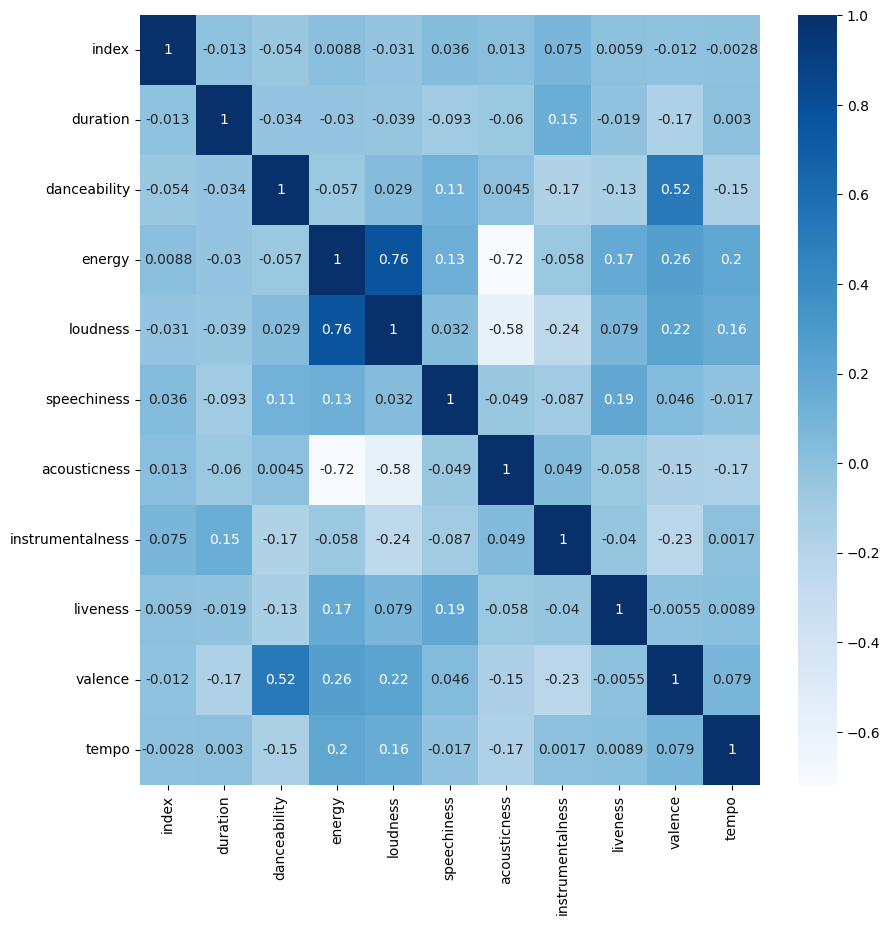

In [27]:
corr = tracks_quanti_feats.corr()
plt.figure(figsize =(10,10))
sns.heatmap(corr, cmap="Blues", annot=True)

There are no clear correlation between the variables, except
- a rather strong positive correlation between energy and loudness,
- a medium positive correlation between valence and danceability
- a rather strong negative correlation between energy and acousticness

## Multivariate quantitative analysis : PCA

In [28]:
scaler = StandardScaler()
scaler.fit(tracks_quanti_feats)

X = tracks_quanti_feats
X[X.columns] = pd.DataFrame(scaler.fit_transform(X), index=X.index)

In [29]:
pca = PCA()
reduced = pca.fit_transform(X)


### Scree plot

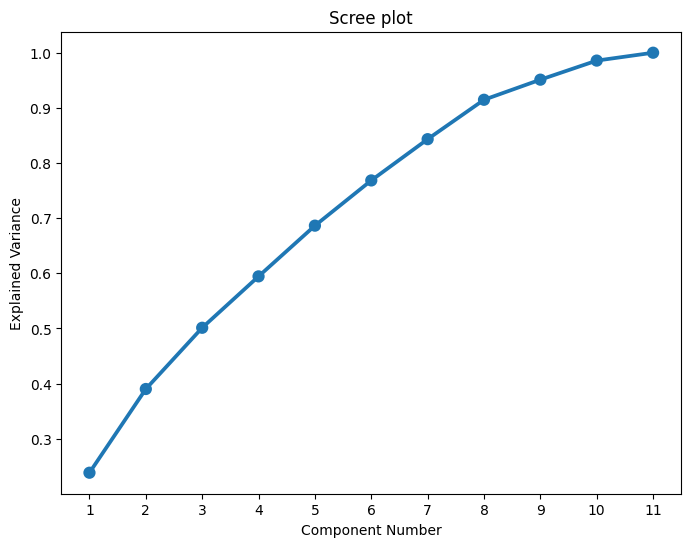

In [30]:
ind = np.arange(0, reduced.shape[1])
(fig, ax) = plt.subplots(figsize=(8, 6))
sns.pointplot(x=ind, y=np.cumsum(pca.explained_variance_ratio_))
ax.set_title('Scree plot')
ax.set_xticks(ind)
ax.set_xticklabels(ind+1)
ax.set_xlabel('Component Number')
ax.set_ylabel('Explained Variance')
plt.show()

### There is not a clear elbow on the explained variance : Almost 7 components are necessary to explain more than 90% of the variance while the original dataset have 10 variables

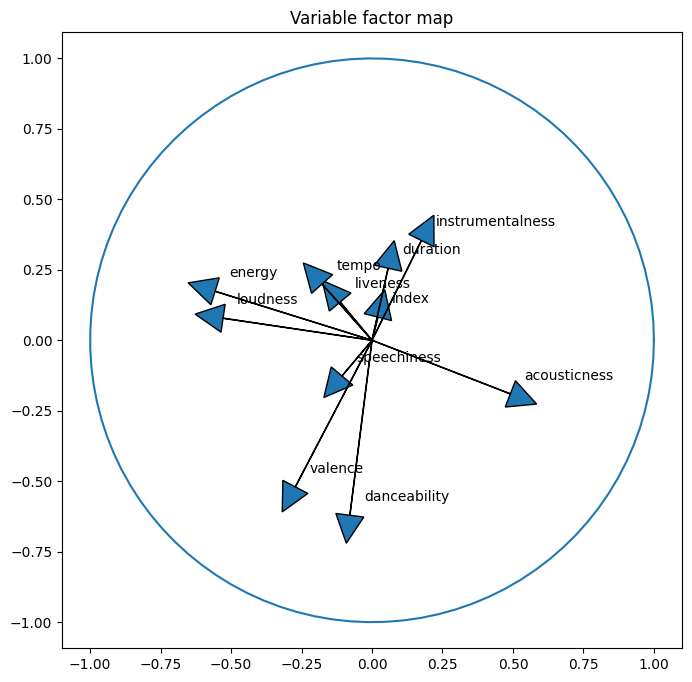

In [31]:
(fig, ax) = plt.subplots(figsize=(8, 8))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.1,
             head_length=0.1)

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             tracks_quanti_feats.columns.values[i])


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
ax.set_title('Variable factor map')
plt.show()

### There is no good correlation between the variables and the first and second component of the ACP. It is unclear

### This short analysis demonstrate that a ACP transformation will not have a clear interest for the dataset.

## Clustering analysis

In [32]:
# Kmeans

distorsions = []

for i in range(100):
    clf = KMeans(n_clusters = i+2, n_init = 'auto')
    clf.fit(X)
    centroids = clf.cluster_centers_
    labels = clf.labels_
    distorsions.append(sum(np.min(cdist(XA = centroids, XB = X, metric='euclidean'), axis = 0)) / len(df))

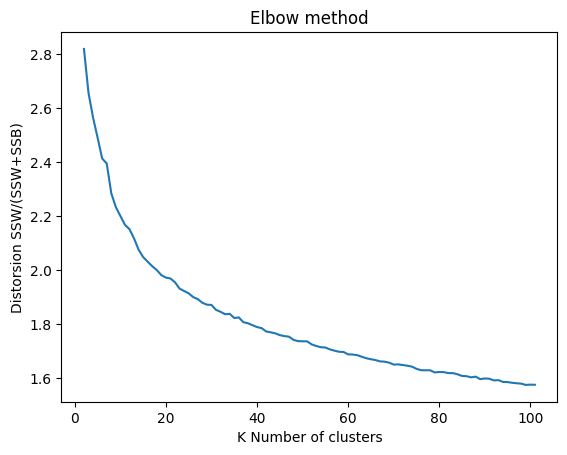

In [33]:
plt.plot([i+2 for i in range(100)], distorsions)
plt.xlabel('K Number of clusters')
plt.ylabel('Distorsion SSW/(SSW+SSB)')
plt.title('Elbow method');


### There's no clear elbow in the silhouette score of the Kmeans clustering with euclidean distance

In [34]:
# Hierarchical Clustering
Z = linkage(X, method = 'ward', metric = 'euclidean')

In [35]:
range_n_clusters = [i+2 for i in range(50)]

s_scores = []
for k in range_n_clusters:
    labels = fcluster(Z, t=k, criterion='maxclust')
    s_scores.append(silhouette_score(X, labels, metric='sqeuclidean'))

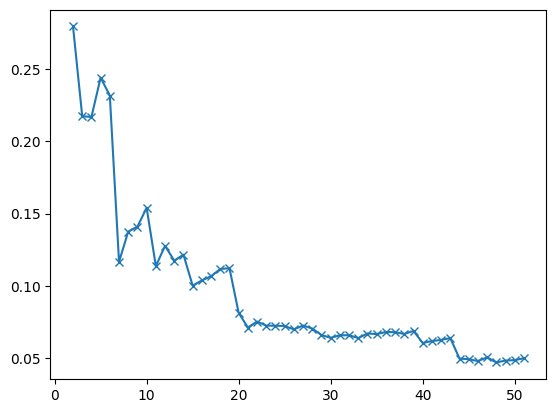

In [36]:
plt.plot(range_n_clusters, s_scores, '-x');

### The removal of redundant information by dropping duplicates of song/artist observations changed the overall silhouette score profile from the initial entire tracks_quanti_feats df

### Let's focus on a smaller range of clusters

In [37]:
range_n_clusters = [i+2 for i in range(15)]
s_scores = []
for n_clusters in range_n_clusters:
    cluster = AgglomerativeClustering(n_clusters=n_clusters)
    cluster.fit(X)
    labels = cluster.labels_
    score = silhouette_score(X, labels, metric='sqeuclidean')
    s_scores.append(score)

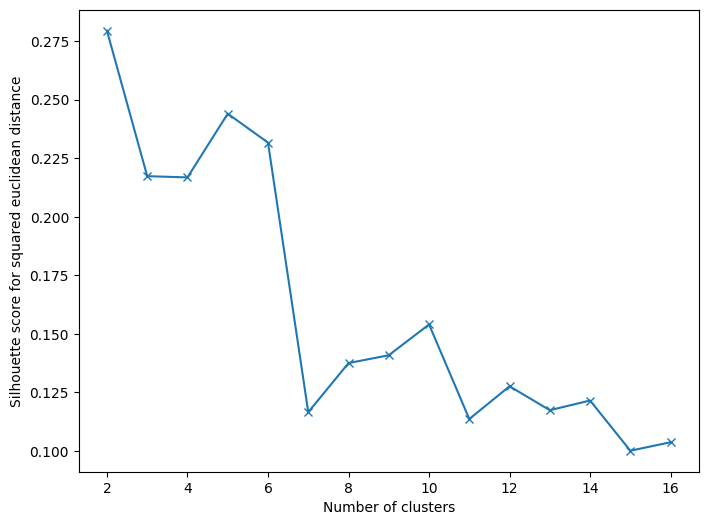

In [38]:
fig, ax1  = plt.subplots(figsize=(8, 6))

ax1.plot(range_n_clusters, s_scores, '-x')
ax1.set_xlabel("Number of clusters")
ax1.set_ylabel("Silhouette score for squared euclidean distance");



### The best silhouette score seems to lie between 2 and 5 clusters for agglomerative clustering with squared euclidean metric

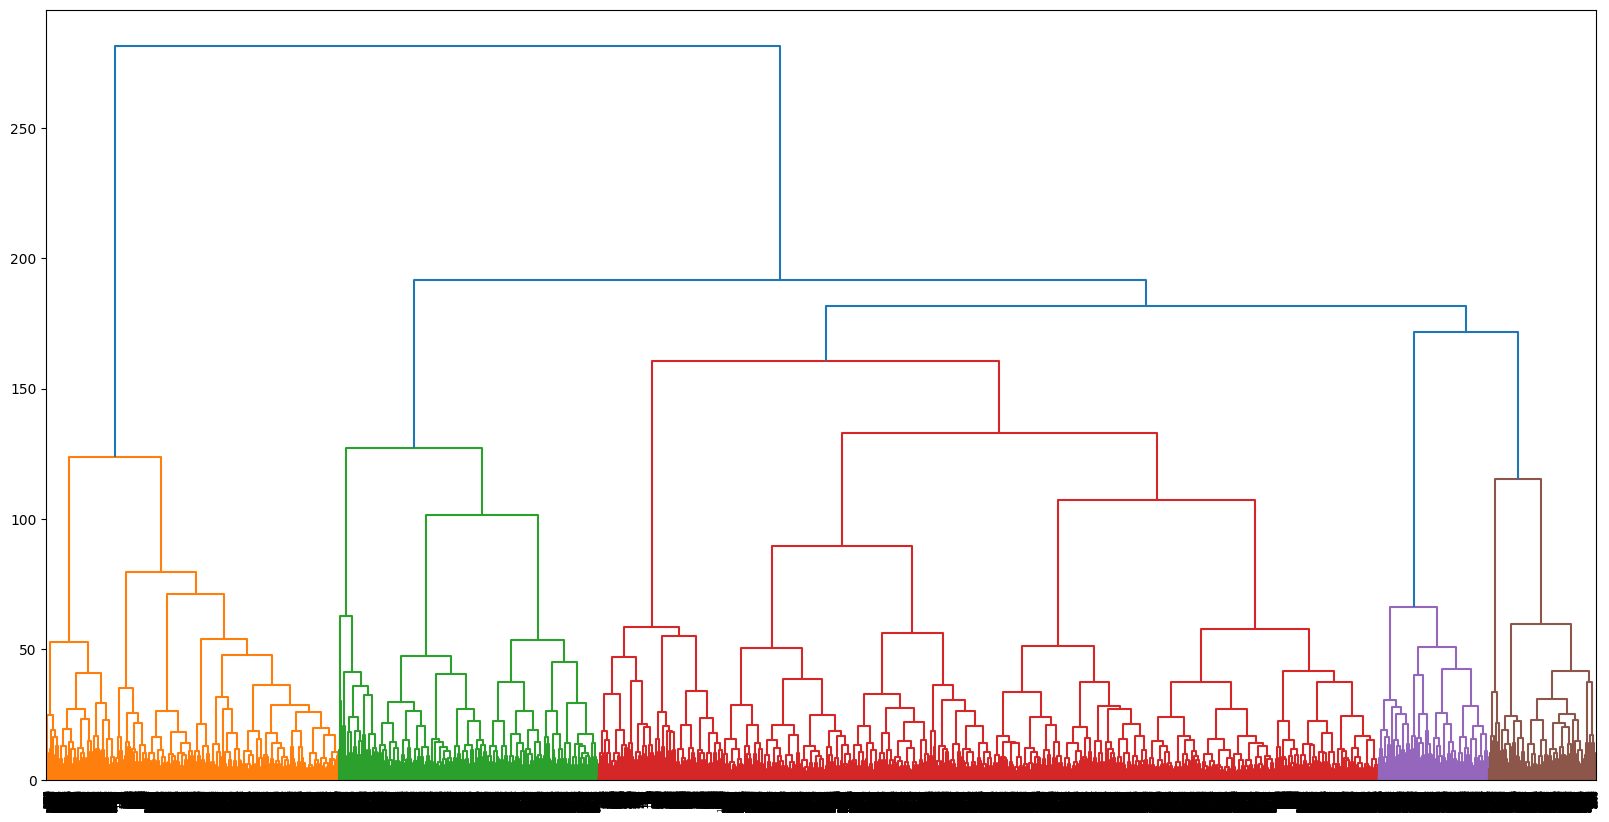

In [40]:
from scipy.cluster.hierarchy import dendrogram
plt.figure(figsize=(20, 10))
dendrogram(Z, labels = tracks_quanti_feats.index, leaf_rotation= 90, color_threshold = 170)
plt.show()

### Two clusters seems like a huge jump, 5 clusters appears to be more conservative as indicated by the dendrogram

In [41]:
n_clusters_cah = 5
cluster = AgglomerativeClustering(n_clusters=n_clusters_cah)
cluster.fit(X)

cah_clusters = cluster.labels_


In [42]:
print(np.unique(cah_clusters))
cah_clusters = cah_clusters.astype('object')

cah_clusters[cah_clusters==0] = 'A'
cah_clusters[cah_clusters==1] = 'B'
cah_clusters[cah_clusters==2] = 'C'
cah_clusters[cah_clusters==3] = 'D'
cah_clusters[cah_clusters==4] = 'E'


[0 1 2 3 4]


In [43]:
X['hac_clusters'] = cah_clusters
print(X['hac_clusters'].unique())


['A' 'B' 'D' 'E' 'C']


In [44]:
X


,index,duration,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,hac_clusters
0,-5.527887,0.633426,0.667073,0.244482,0.234685,0.971940,-0.825165,-0.623569,1.661334,0.055057,-0.585837,A
1,-5.505360,0.123613,-0.048441,1.150060,0.862181,-0.294877,-0.842482,-0.620462,0.105924,0.728483,0.441564,A
2,-5.503192,2.815521,0.868312,0.283685,1.220943,-0.411504,-0.316887,-0.526080,-0.197701,0.039664,-0.893749,A
3,-5.499753,-0.191894,0.180747,1.244146,1.071496,-0.108876,-0.843348,-0.614856,0.260399,0.197438,-0.324244,A
4,-5.498847,-0.388845,-0.501227,1.165741,1.072171,-0.272758,-0.848599,-0.614704,-0.480018,-0.206617,1.169095,A
...,...,...,...,...,...,...,...,...,...,...,...,...
27602,0.600509,0.379722,0.991291,-0.429800,-0.219056,-0.392401,1.575591,-0.623569,0.015369,1.247983,-1.122880,A
27603,0.600510,-0.537460,-0.395018,-1.370660,-0.236161,-0.523105,1.705467,-0.520901,0.825034,-1.007032,-0.805067,B
27604,0.600511,-0.697378,0.583224,0.228801,0.703957,-0.425580,-0.754445,-0.623329,-0.543939,-0.679940,0.473561,A
27605,0.600512,0.209464,-0.283219,-2.126092,-3.399071,-0.445688,2.187863,2.115258,3.328605,-0.899284,-1.731493,B


C:\Users\benoit\AppData\Local\Temp\ipykernel_20688\2454631998.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(251)


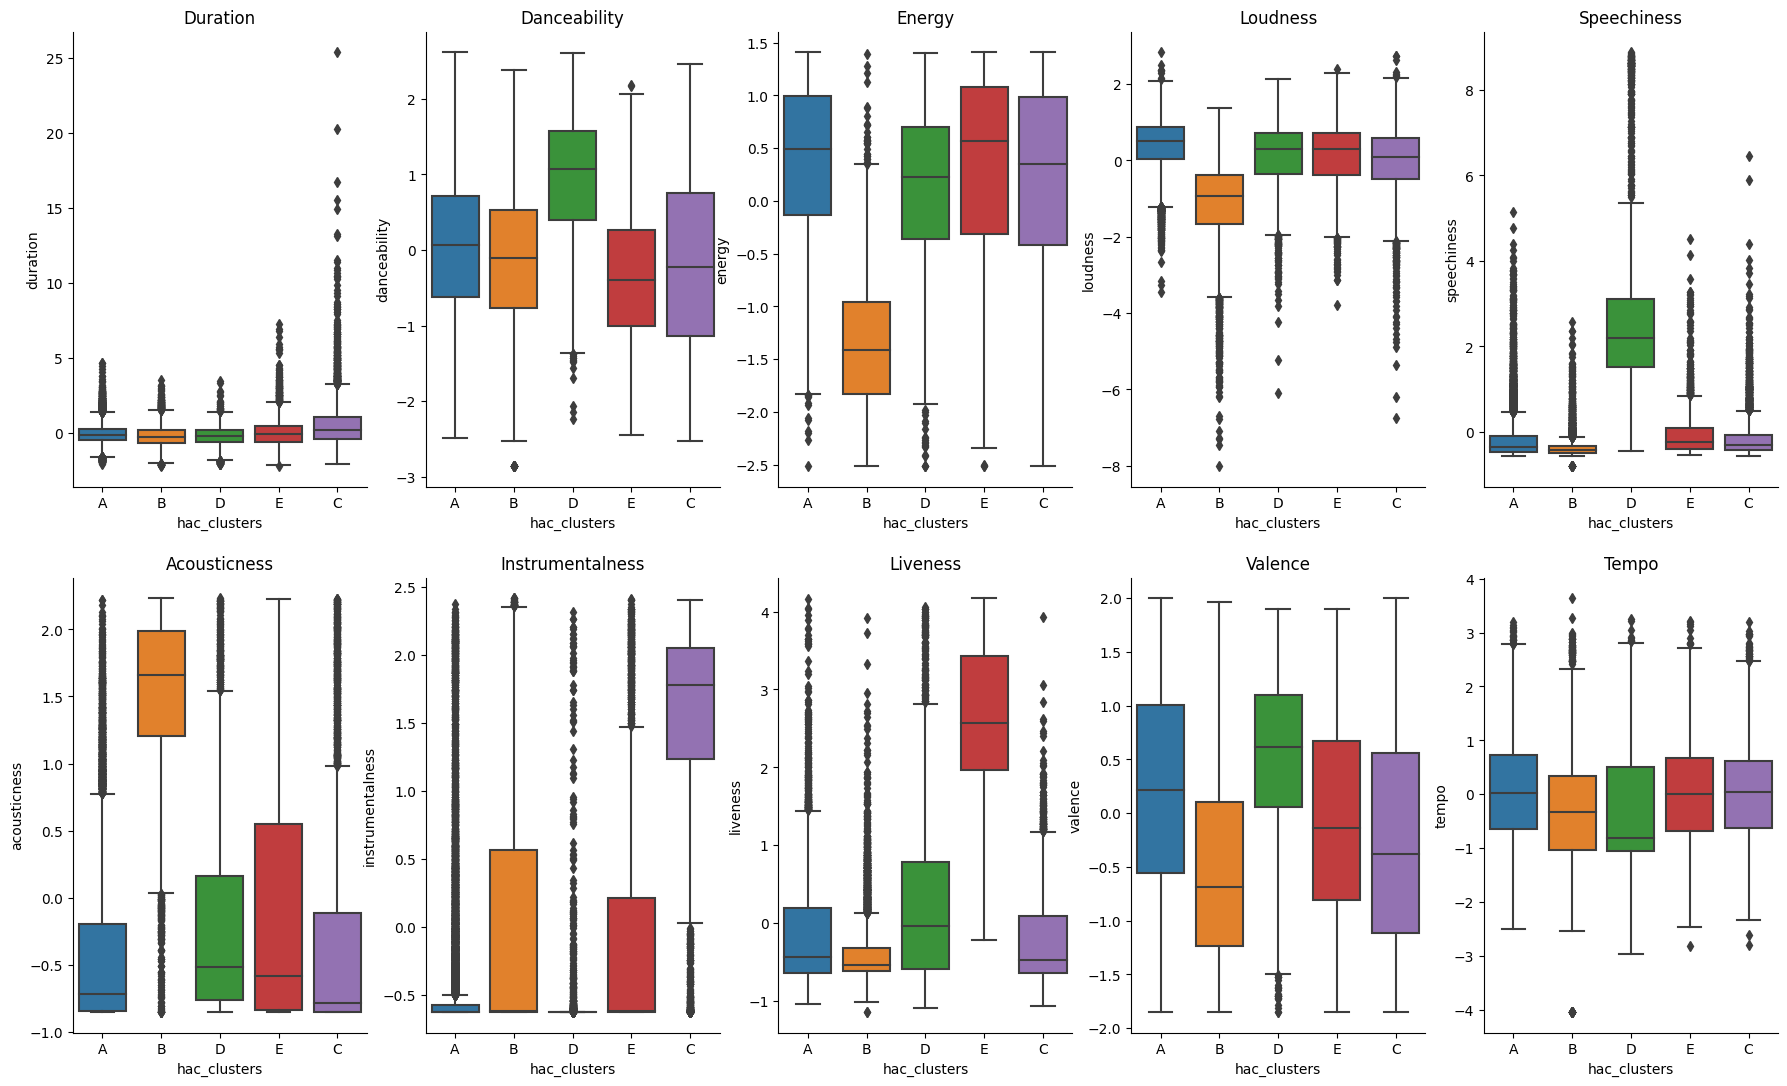

In [53]:
fig = plt.subplots(figsize=(22, 13))

ax1 = plt.subplot(251)
a = sns.boxplot(x='hac_clusters', y='duration', hue = 'hac_clusters', data=X, dodge=False, ax=ax1)
a.legend_.remove()
a.set_title("Duration")
sns.despine();

ax2 = plt.subplot(252)
b = sns.boxplot(x='hac_clusters', y='danceability', hue = 'hac_clusters', data=X, dodge=False, ax=ax2)
b.legend_.remove()
b.set_title("Danceability")
sns.despine();

ax3 = plt.subplot(253)
c = sns.boxplot(x='hac_clusters', y='energy', hue = 'hac_clusters', data=X, dodge=False, ax=ax3)
c.legend_.remove()
c.set_title("Energy")
sns.despine();

ax4 = plt.subplot(254)
d = sns.boxplot(x='hac_clusters', y='loudness', hue = 'hac_clusters', data=X, dodge=False, ax=ax4)
d.legend_.remove()
d.set_title("Loudness")
sns.despine();

ax5 = plt.subplot(255)
e = sns.boxplot(x='hac_clusters', y='speechiness', hue = 'hac_clusters', data=X, dodge=False, ax=ax5)
e.set_title("Speechiness")
e.legend_.remove()
sns.despine();

ax6 = plt.subplot(256)
f = sns.boxplot(x='hac_clusters', y='acousticness', hue = 'hac_clusters', data=X, dodge=False, ax=ax6)
f.legend_.remove()
f.set_title("Acousticness")
sns.despine();

ax7 = plt.subplot(257)
g = sns.boxplot(x='hac_clusters', y='instrumentalness', hue = 'hac_clusters', data=X, dodge=False, ax=ax7)
g.legend_.remove()
g.set_title("Instrumentalness")
sns.despine();

ax8 = plt.subplot(258)
h = sns.boxplot(x='hac_clusters', y='liveness', hue = 'hac_clusters', data=X, dodge=False, ax=ax8)
h.legend_.remove()
h.set_title("Liveness")
sns.despine();

ax9 = plt.subplot(259)
i = sns.boxplot(x='hac_clusters', y='valence', hue = 'hac_clusters', data=X, dodge=False, ax=ax9)
i.legend_.remove()
i.set_title("Valence")
sns.despine();

ax10 = plt.subplot(2,5,10)
j = sns.boxplot(x='hac_clusters', y='tempo', hue = 'hac_clusters', data=X, dodge=False, ax=ax10)
j.legend_.remove()
j.set_title("Tempo")
sns.despine();


In [54]:
df_mapping = X
df_mapping['song_name'] =  df['song_name']
df_mapping['artist_name'] =  df['artist_name']
df_mapping = df_mapping.drop(['index'], axis=1)
df_mapping

,duration,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,hac_clusters,song_name,artist_name
0,0.633426,0.667073,0.244482,0.234685,0.971940,-0.825165,-0.623569,1.661334,0.055057,-0.585837,A,Stronger,Kanye West
1,0.123613,-0.048441,1.150060,0.862181,-0.294877,-0.842482,-0.620462,0.105924,0.728483,0.441564,A,Stacked Actors,Foo Fighters
2,2.815521,0.868312,0.283685,1.220943,-0.411504,-0.316887,-0.526080,-0.197701,0.039664,-0.893749,A,Clarity,John Mayer
3,-0.191894,0.180747,1.244146,1.071496,-0.108876,-0.843348,-0.614856,0.260399,0.197438,-0.324244,A,Gimme Stitches,Foo Fighters
4,-0.388845,-0.501227,1.165741,1.072171,-0.272758,-0.848599,-0.614704,-0.480018,-0.206617,1.169095,A,Breakout,Foo Fighters
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27602,0.379722,0.991291,-0.429800,-0.219056,-0.392401,1.575591,-0.623569,0.015369,1.247983,-1.122880,A,Dime,Jerry Rivera
27603,-0.537460,-0.395018,-1.370660,-0.236161,-0.523105,1.705467,-0.520901,0.825034,-1.007032,-0.805067,B,The Long Conversation,Pierre de Reeder
27604,-0.697378,0.583224,0.228801,0.703957,-0.425580,-0.754445,-0.623329,-0.543939,-0.679940,0.473561,A,That's the Way That It Was,Pierre de Reeder
27605,0.209464,-0.283219,-2.126092,-3.399071,-0.445688,2.187863,2.115258,3.328605,-0.899284,-1.731493,B,I'll Close My Eyes,Mike Jones


In [55]:
df_tracks_feats = df_mapping
df_tracks_feats = df_tracks_feats.drop(['duration', 'hac_clusters'], axis=1)
df_mapping = df_mapping.drop(['duration', 'danceability', 'energy',
                              'loudness', 'speechiness', 'acousticness',
                              'instrumentalness', 'liveness', 'valence', 'tempo'],
                              axis=1)


df_tracks_feats

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,song_name,artist_name
0,0.667073,0.244482,0.234685,0.971940,-0.825165,-0.623569,1.661334,0.055057,-0.585837,Stronger,Kanye West
1,-0.048441,1.150060,0.862181,-0.294877,-0.842482,-0.620462,0.105924,0.728483,0.441564,Stacked Actors,Foo Fighters
2,0.868312,0.283685,1.220943,-0.411504,-0.316887,-0.526080,-0.197701,0.039664,-0.893749,Clarity,John Mayer
3,0.180747,1.244146,1.071496,-0.108876,-0.843348,-0.614856,0.260399,0.197438,-0.324244,Gimme Stitches,Foo Fighters
4,-0.501227,1.165741,1.072171,-0.272758,-0.848599,-0.614704,-0.480018,-0.206617,1.169095,Breakout,Foo Fighters
...,...,...,...,...,...,...,...,...,...,...,...
27602,0.991291,-0.429800,-0.219056,-0.392401,1.575591,-0.623569,0.015369,1.247983,-1.122880,Dime,Jerry Rivera
27603,-0.395018,-1.370660,-0.236161,-0.523105,1.705467,-0.520901,0.825034,-1.007032,-0.805067,The Long Conversation,Pierre de Reeder
27604,0.583224,0.228801,0.703957,-0.425580,-0.754445,-0.623329,-0.543939,-0.679940,0.473561,That's the Way That It Was,Pierre de Reeder
27605,-0.283219,-2.126092,-3.399071,-0.445688,2.187863,2.115258,3.328605,-0.899284,-1.731493,I'll Close My Eyes,Mike Jones


In [56]:
df_mapping[df_mapping['song_name']=='Stronger']

,hac_clusters,song_name,artist_name
0,A,Stronger,Kanye West
741,A,Stronger,Britney Spears
16999,A,Stronger,Will Young
20133,B,Stronger,Carlene Carter
22370,A,Stronger,Mieka Pauley


In [57]:
df_origin = pd.read_csv(FILE_PATH)

### Broadcast hac_clusters of df_mapping for same song_name/artist_name couple on the entire df for each user previously dropped as duplicate

In [60]:
df_origin = pd.merge(df_origin, df_mapping, on=['song_name', 'artist_name'], how='left')
df_origin

,user,listening_count,song_name,release,artist_name,duration,artist_familiarity,artist_hotttnesss,year,shs_perf,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_date,hac_clusters_x,hac_clusters_y,hac_clusters
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,Stronger,Graduation,Kanye West,311.84934,0.877214,1.082503,2007,-1,...,0.00763,0.000000,0.526,0.495,103.977,4.0,2011-05-24,A,A,A
1,9fba771d9731561eba47216f6fbfc0023d88641b,19,Stronger,Graduation,Kanye West,311.84934,0.877214,1.082503,2007,-1,...,0.00763,0.000000,0.526,0.495,103.977,4.0,2011-05-24,A,A,A
2,85952991b8e3ca5803a08b0b2f9c6d71abf9bb5b,1,Stronger,Graduation,Kanye West,311.84934,0.877214,1.082503,2007,-1,...,0.00763,0.000000,0.526,0.495,103.977,4.0,2011-05-24,A,A,A
3,537340ff896dea11328910013cfe759413e1eeb3,2,Stronger,Graduation,Kanye West,311.84934,0.877214,1.082503,2007,-1,...,0.00763,0.000000,0.526,0.495,103.977,4.0,2011-05-24,A,A,A
4,8fce200f3912e9608e3b1463cdb9c3529aab5c08,2,Stronger,Graduation,Kanye West,311.84934,0.877214,1.082503,2007,-1,...,0.00763,0.000000,0.526,0.495,103.977,4.0,2011-05-24,A,A,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4982515,3796a24e109961914e04fc82f05e727751eba723,1,Dime,20th Anniversary,Jerry Rivera,284.29016,0.650177,0.404963,2001,-1,...,0.78400,0.000000,0.217,0.805,87.814,4.0,2016-08-12,A,A,A
4982516,61457d4f6b5053031c358de46929960f3d32d782,1,The Long Conversation,The Way That It Was,Pierre de Reeder,184.65914,0.511732,0.344567,2008,-1,...,0.82600,0.033700,0.369,0.219,97.379,4.0,2010-04-20,B,B,B
4982517,61457d4f6b5053031c358de46929960f3d32d782,1,That's the Way That It Was,The Way That It Was,Pierre de Reeder,167.28771,0.511732,0.344567,2008,-1,...,0.03050,0.000079,0.112,0.304,135.861,4.0,2010-04-20,A,A,A
4982518,bd0c3b42396ea8a1225eba1ac8c398b940e1b060,3,I'll Close My Eyes,Runnin Wild,Mike Jones,265.79546,0.793605,0.426318,0,-1,...,0.98200,0.899000,0.839,0.247,69.497,4.0,1994,B,B,B


In [61]:
scaler = StandardScaler()
sel_columns = ['duration', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
df_origin[sel_columns] = pd.DataFrame(scaler.fit_transform(df_origin[sel_columns]), index=df_origin.index)


In [20]:
## function to loop over the df to obtain fraction of listenings per cluster classes

def get_user_class_fraction(df : pd.DataFrame, user_id: str, clusters: list[str]):
    total_listening = df[df["user"] == user_id]["listening_count"].sum() 
    clusters.sort()
    listening_classes = []
    for cluster in clusters:
        listening_classes.append(df[(df["user"] == user_id) & (df["hac_clusters"] == cluster)]["listening_count"].sum() / total_listening)
    return total_listening, listening_classes



### Loop for each cluster class, for top 10 extreme and various users to obtain the fraction of listenings per class and the total number of listenings

In [21]:


ach_list = ['A', 'B', 'C', 'D', 'E']
top_10_various_listeners = ["ec6dfcf19485cb011e0b22637075037aae34cf26", "4e73d9e058d2b1f2dba9c1fe4a8f416f9f58364f",
                    "952130c8ae0527458c75471812dbb5c506b46d5d", "b4c94d72b15d3c311c10045a58b31f95d9d12785",
                    "8192a1d3ca0afbbcf1c98d7062d573e9207078e6", "6d625c6557df84b60d90426c0116138b617b9449",
                    "8cb51abc6bf8ea29341cb070fe1e1af5e4c3ffcc", "fef771ab021c200187a419f5e55311390f850a50",
                    "cbc7bddbe3b2f59fdbe031b3c8d0db4175d361e6", "726da71c2c2ea119119a7957517fccd028d1be76"]

top_10_v_n = []
top_10_various_users = []
for i in top_10_various_listeners:
    listen_n, classes = get_user_class_fraction(df=df_origin, user_id=i, clusters = ach_list)
    top_10_v_n.append(listen_n)
    top_10_various_users.append(classes)


top_10_listeners = ["22e08d5e101ab5b86dc394856d508e175a5242a6", "af3ee32357049dd96231238bd1b019e8142ee6aa",
                    "6a6d346cc92ee699a765a06fd97db74b864a8129", "3fa44653315697f42410a30cb766a4eb102080bb",
                    "6a46aee45cc177cf8e2025e59d21c7939902deee", "716ed1ec67d67bfa05db3ffeb641d13f46dca6ec",
                    "9755e6e2faf1ba2e1e46f8227690847511425bab", "44d6db05e087361c30a3862db756b9530b5ed14d",
                    "19a7ec5c51a370817f99cf18decde4b8f469bfd3", "9d17a429365653228049e8fe3d5968d4cd5dc6fe"]

top_10_n = []
top_10_users = []
for i in top_10_listeners:
    listen_n, classes = get_user_class_fraction(df=df_origin, user_id=i, clusters = ach_list)
    top_10_n.append(listen_n)
    top_10_users.append(classes)



### Plot various user fraction of listenings per track acoustic characteristics cluster

C:\Users\benoit\AppData\Local\Temp\ipykernel_30120\3051137266.py:62: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2,5,i+1)


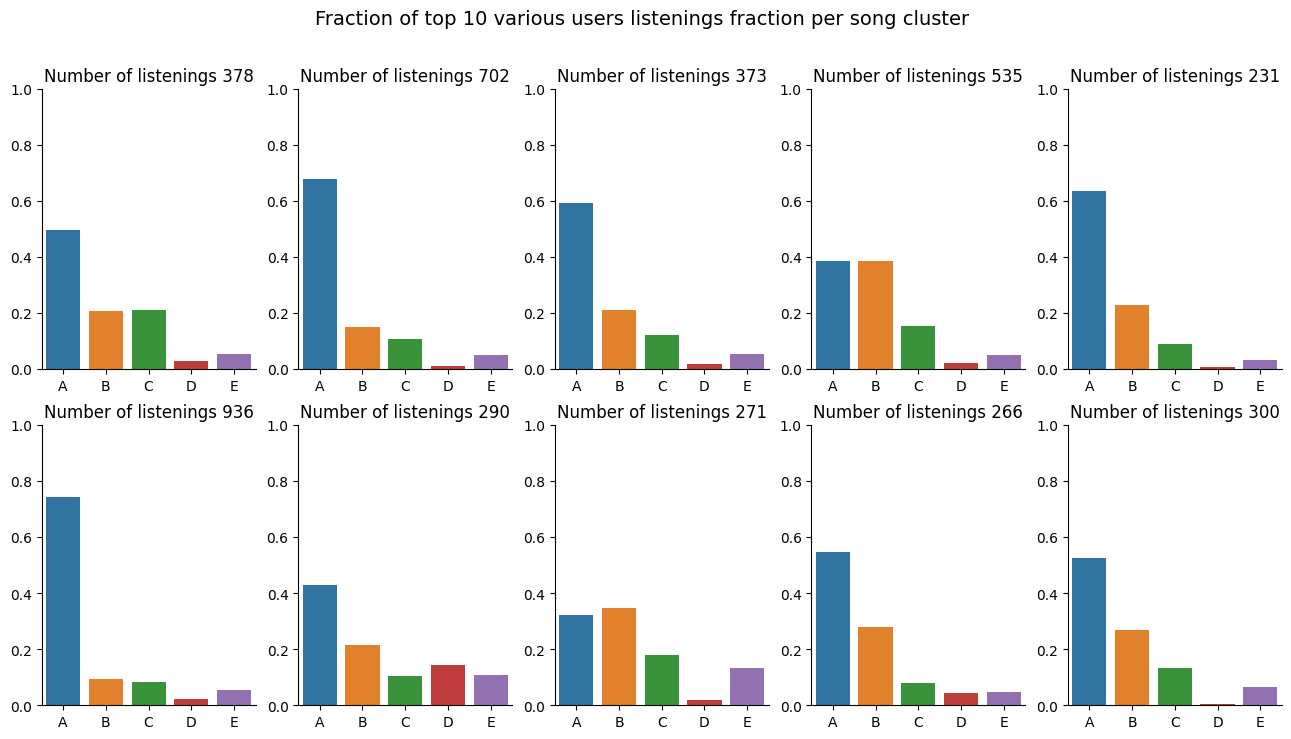

In [22]:
fig, axs = plt.subplots(figsize=(16, 8))
plt.suptitle("Fraction of top 10 various users listenings fraction per song cluster", fontsize= 14)

for i in range(10):
    ax = plt.subplot(2,5,i+1)
    a = sns.barplot(x=ach_list, y=top_10_various_users[i], dodge=False, ax=ax)
    a.set_title("Number of listenings " + str(top_10_v_n[i]))
    a.set_ylim(0,1)
    sns.despine()

Plot extreme users fraction

C:\Users\benoit\AppData\Local\Temp\ipykernel_30120\969784757.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2,5,i+1)


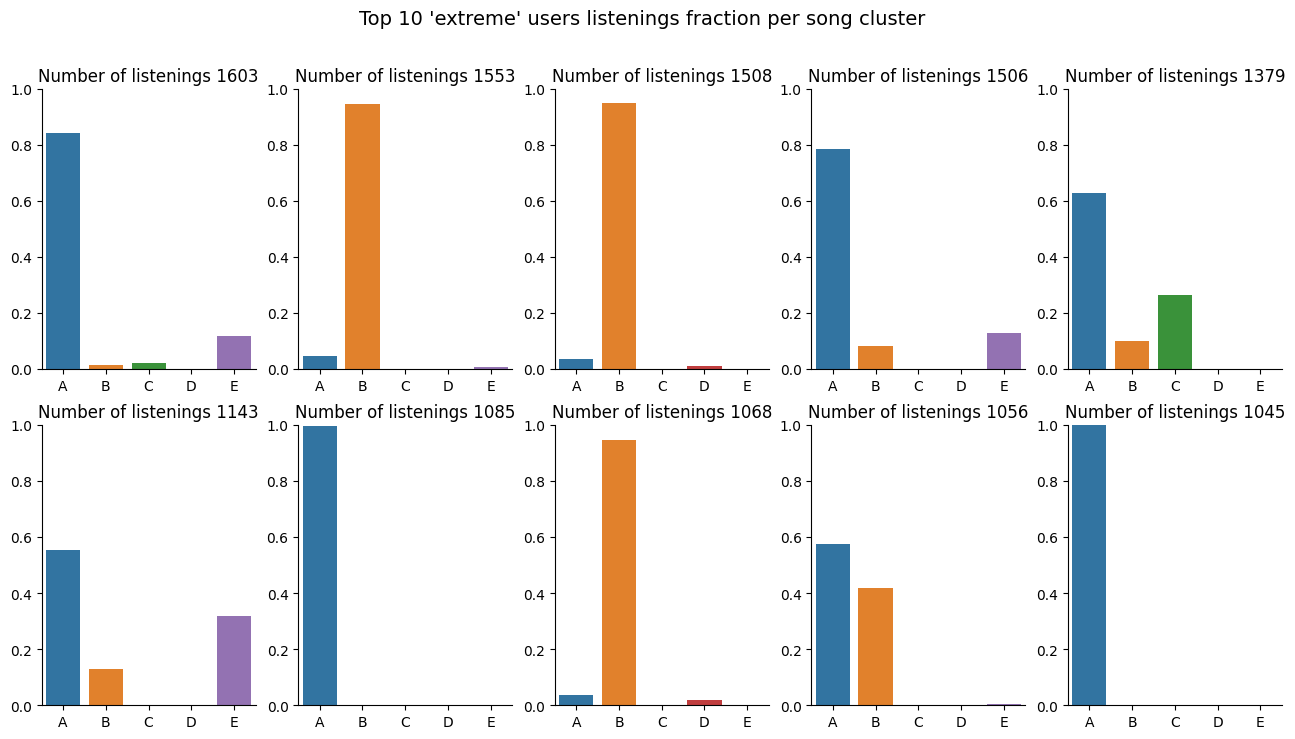

In [23]:
fig, axs = plt.subplots(figsize=(16, 8))
plt.suptitle("Top 10 'extreme' users listenings fraction per song cluster", fontsize= 14)

for i in range(10):
    ax = plt.subplot(2,5,i+1)
    a = sns.barplot(x=ach_list, y=top_10_users[i], dodge=False, ax=ax)
    a.set_title("Number of listenings " + str(top_10_n[i]))
    a.set_ylim(0,1)
    sns.despine()


In [24]:
print(df_mapping["hac_clusters"].value_counts(normalize=True))
print('-' * 20)
print("The clusters are originally imbalanced")
print('-' * 20)
print(df_origin["hac_clusters"].value_counts(normalize=True))
print('-' * 20)
print("This disequilibrium is amplified in the original dataframe")


hac_clusters
A    0.433332
B    0.261818
C    0.173760
D    0.066577
E    0.064513
Name: proportion, dtype: float64
--------------------
The clusters are originally imbalanced
--------------------
hac_clusters
A    0.527333
B    0.242869
C    0.109556
E    0.063385
D    0.056857
Name: proportion, dtype: float64
--------------------
This disequilibrium is amplified in the original dataframe


### Let's correct the fraction of listening per clusters by the weight of each cluster and normalize it

In [25]:
clusters_fractions = df_mapping["hac_clusters"].value_counts(normalize=True).tolist()
weighted_fractions = np.asarray(top_10_various_users) / np.asarray(clusters_fractions)
                       
for i in range(len(weighted_fractions)):
    weighted_fractions[i] /= weighted_fractions[i].sum() 

weighted_fractions = weighted_fractions.tolist()


C:\Users\benoit\AppData\Local\Temp\ipykernel_30120\427497796.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2,5,i+1)


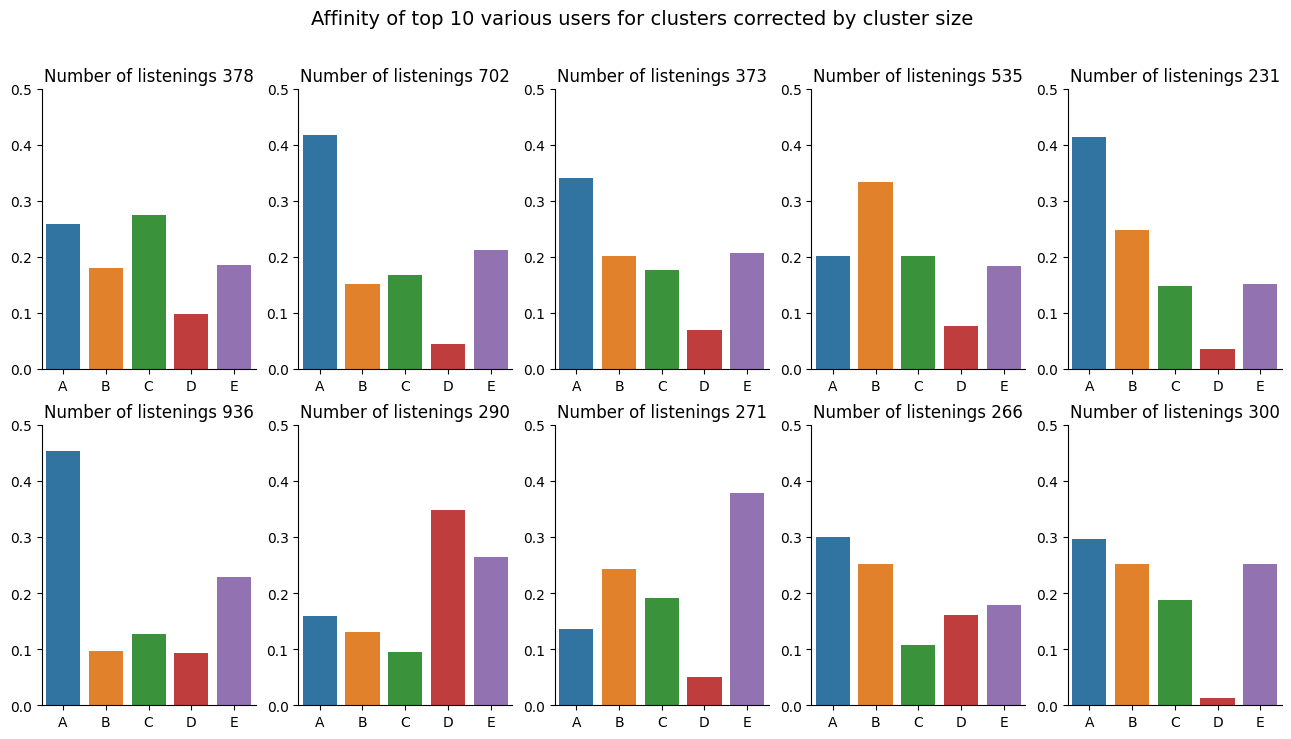

In [26]:
fig, axs = plt.subplots(figsize=(16, 8))
plt.suptitle("Affinity of top 10 various users for clusters corrected by cluster size", fontsize= 14)

for i in range(10):
    ax = plt.subplot(2,5,i+1)
    a = sns.barplot(x=ach_list, y= weighted_fractions[i] , dodge=False, ax=ax)
    a.set_title("Number of listenings " + str(top_10_v_n[i]))
    a.set_ylim(0,0.5)
    sns.despine()

In [ ]:
df_tracks_feats_names = df_tracks_feats
df_tracks_feats = df_tracks_feats.drop(['song_name', 'artist_name'], axis=1)

#df_tracks_feats_names
df_tracks_feats

In [ ]:
scaler = StandardScaler()
sel_columns = ['duration', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
df_origin[sel_columns] = pd.DataFrame(scaler.fit_transform(df_origin[sel_columns]), index=df_origin.index)
df_origin.columns

In [826]:
def get_opt_clusters(df:pd.DataFrame, drop : list[str], user_id: str):
    
    # definition of df_user
    df_user = df[df['user']==user_id].drop(drop, axis=1).reset_index().drop(['index'], axis=1)

    # weights to apply to the kmeans
    user_listenings = df_user['listening_count']

    # eliminate weights from acoustic characteristics
    df_user = df_user.drop('listening_count', axis=1) 
    

    # broad exploration of number of clusters
    dist = []
    s_scores = []
    range = np.arange(2,17)
    for i in range:
        clf = KMeans(n_clusters = i, n_init = 'auto', random_state=123)
        clf.fit(df_user, sample_weight=user_listenings)
        centroids = clf.cluster_centers_
        labels = clf.labels_
        score = silhouette_score(df_user, labels, metric='euclidean')
        s_scores.append(score)
        dist.append(sum(np.min(cdist(XA = centroids, XB = df_user, metric='euclidean'), axis = 0)) / len(df_user))
    
    # optimal number of clusters selection by silhouette score
    n_clusters = s_scores.index(max(s_scores))+2

    return range, s_scores, dist, n_clusters

In [827]:
def get_user_profiles(df: pd.DataFrame, drop : list[str],  user_id: str, n_clusters:int):
    """
    Takes a user_id string and 1 dataframe containg all original informations and whose acoustic characteristics are Standard scaled.
    Returns the acoustic characteristics of the user standard profile weighted by number of listenings (1 acoustic profile)   
    and the cluster centers centroids profiles based on Kmeans fit on optimal number of cluster found per user (n_clusters profiles)

    Parameters:
        df : whole dataframe with all acoustic characteristics Standard scaled
        user_id : str corresponding to the user id
   
    Return :
        
        standard_profile: list[list[float]] of size 1
        cluster_profile: list[list[float]] of size n_clusters
    """
    
    
    total_listening = df[df["user"] == user_id]["listening_count"].sum() 

    ## Standard profile: one profile where acoustic characteristics are weighted by listening_count
    duration = 0
    dance = 0
    energy = 0
    loudness = 0
    speech = 0
    acoustic = 0
    instru = 0
    live = 0
    valence = 0
    tempo = 0


    # cumulative sum of user's  songs acoustic characteristics weighted by listening_count
    for index, row, in df[df["user"] == user_id].iterrows():
        #duration += row['duration'] * row["listening_count"]
        dance += row['danceability'] * row["listening_count"]
        energy += row['energy'] * row["listening_count"]
        loudness += row['loudness'] * row["listening_count"]
        speech += row['speechiness'] * row["listening_count"]
        acoustic += row['acousticness'] * row["listening_count"]
        instru += row['instrumentalness'] * row["listening_count"]
        live += row['liveness'] * row["listening_count"]
        valence += row['valence'] * row["listening_count"]
        tempo += row['tempo'] * row["listening_count"]

    # duration / total_listening, 

    # weighted average from cumulative sum of acoustic characteristics / total_listening to list of lists
    standard_profile = [[dance / total_listening, energy / total_listening,
                        loudness / total_listening, speech / total_listening, acoustic / total_listening,
                        instru / total_listening, live / total_listening, valence / total_listening,
                        tempo / total_listening]]

    
    ## Cluster profile
    # definition of df_user
    df_user = df[df['user']==user_id].drop(drop, axis=1).reset_index().drop(['index'], axis=1)

    # weights to apply to the kmeans
    user_listenings = df_user['listening_count']

    # eliminate weights from acoustic characteristics
    df_user = df_user.drop('listening_count', axis=1) 

    # training of kmeans with optimal number of clusters
    clf = KMeans(n_clusters = n_clusters, n_init = 'auto', random_state=123)
    clf.fit(df_user, sample_weight=user_listenings)
    centroids = clf.cluster_centers_
    labels = clf.labels_

    # distinct profiles as cluster centers centroids to list
    cluster_profile = centroids.tolist()

    
    return standard_profile, cluster_profile

### Proximity measure - Numerical resolution for a single test user 

In [842]:
# var
acoustic_variables = ["Danceability", "Energy", "Loudness", "Speechiness", "Acousticness", "instrumentalness", "Liveness", "Valence", "Tempo"]
n_neighbors = 5
user_name = "ec6dfcf19485cb011e0b22637075037aae34cf26"
to_drop = ['user', 'song_name', 'release', 'artist_name', 'duration', 'artist_familiarity', 'artist_hotttnesss', 
           'year', 'shs_perf', 'shs_work', 'key', 'mode', 'explicit', 'time_signature', 'release_date', 'hac_clusters']

# func
range_n_clusters, silhouette_scores, distorsions, n_opt_cluster = get_opt_clusters(df=df_origin, drop=to_drop, user_id=user_name)

standard_profile, clusters_profiles = get_user_profiles(df=df_origin, drop=to_drop, user_id=user_name, n_clusters=n_opt_cluster)





C:\Users\benoit\AppData\Local\Temp\ipykernel_30120\2816053639.py:3: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



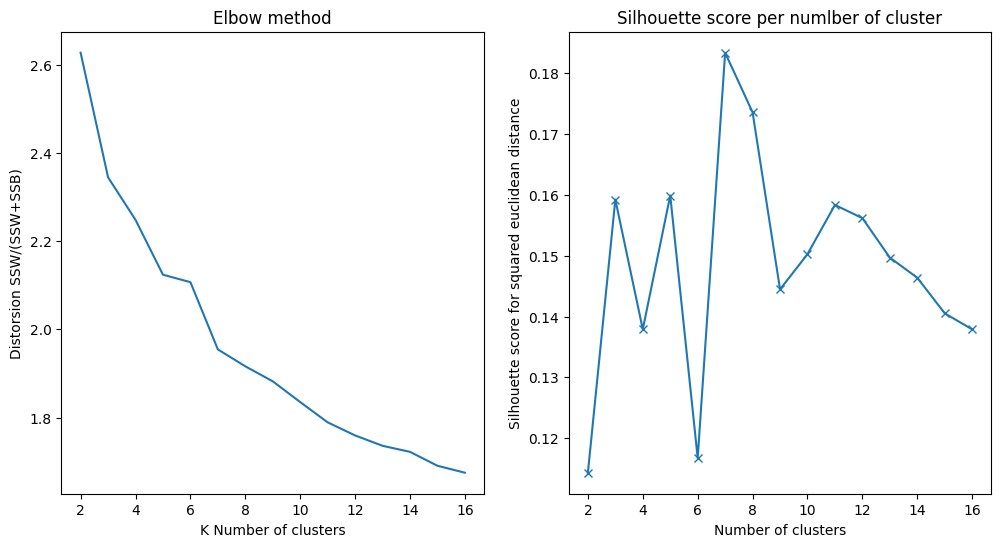

In [837]:
fig  = plt.subplots(figsize=(12, 6))

ax1 = plt.subplot(121)
ax1.plot(range_n_clusters, distorsions)
ax1.set_xlabel('K Number of clusters')
ax1.set_ylabel('Distorsion SSW/(SSW+SSB)')
ax1.set_title('Elbow method');

ax2 = plt.subplot(122)
ax2.plot(range_n_clusters, s_scores, '-x')
ax2.set_xlabel("Number of clusters")
ax2.set_ylabel("Silhouette score for squared euclidean distance")
ax2.set_title('Silhouette score per number of cluster');

In [830]:
from scipy.spatial import distance_matrix

def get_profile_neighbors(df_features, df_features_names: pd.DataFrame, profile: list[list[float]], n_target : int = n_neighbors):
    
    user_profile = pd.DataFrame(columns=["danceability", "energy",
                                   "loudness", "speechiness", "acousticness",
                                   "instrumentalness", "liveness", "valence",
                                   "tempo"])
    

    # append profile to the dataframe user_profile
    for i in range(len(profile)):
        user_profile.loc[len(user_profile)] = profile[i]


    # compute the distance matrix between all user_profiles and all songs features
    dist_mat = pd.DataFrame(distance_matrix(user_profile, df_features).T)
    #dist_mat = dist_mat.rename(columns={0 : 'distance'})
    

    # create similarity and disimilarity lists
    sim = []
    dis = []
    sim_id = []
    dis_id =[]

    # broadcast distance of matrix[i] to df_features_names containing song and artist names and sort values by distance[i]
    for i in range(len(profile)):
        df_feats_names = df_features_names
        df_feats_names[i] = dist_mat[i]
        df_feats_names = df_feats_names.sort_values(by=i, ascending=True).reset_index().drop(['index'], axis=1)
        
        # for each profile create temporary sim and disim lists
        s = []
        d = []
        s_id = []
        d_id = []

        ## append each profile list the profile closest and furthest n_neighbors tracks and corresponding song-artist names 
        for j in range (n_target):
            s.append(df_feats_names.iloc[j, :9].values.flatten().tolist())
            s_id.append(' - '.join((df_feats_names.iloc[j, 9:11])))
            
            d.append(df_feats_names.iloc[len(df_feats_names)-1-j, :9].values.flatten().tolist())
            d_id.append(' - '.join((df_feats_names.iloc[len(df_feats_names)-1-j, 9:11])))
        
        
        sim.append(s)
        sim_id.append(s_id)
        dis.append(d)
        dis_id.append(d_id)

    return sim, dis, sim_id, dis_id


In [849]:
#similar, disimilar, sim_names, dis_names = get_profile_neighbors(df_tracks_feats, df_tracks_feats_names, standard_profile)
similar, disimilar, sim_names, dis_names = get_profile_neighbors(df_tracks_feats, df_tracks_feats_names, clusters_profiles)


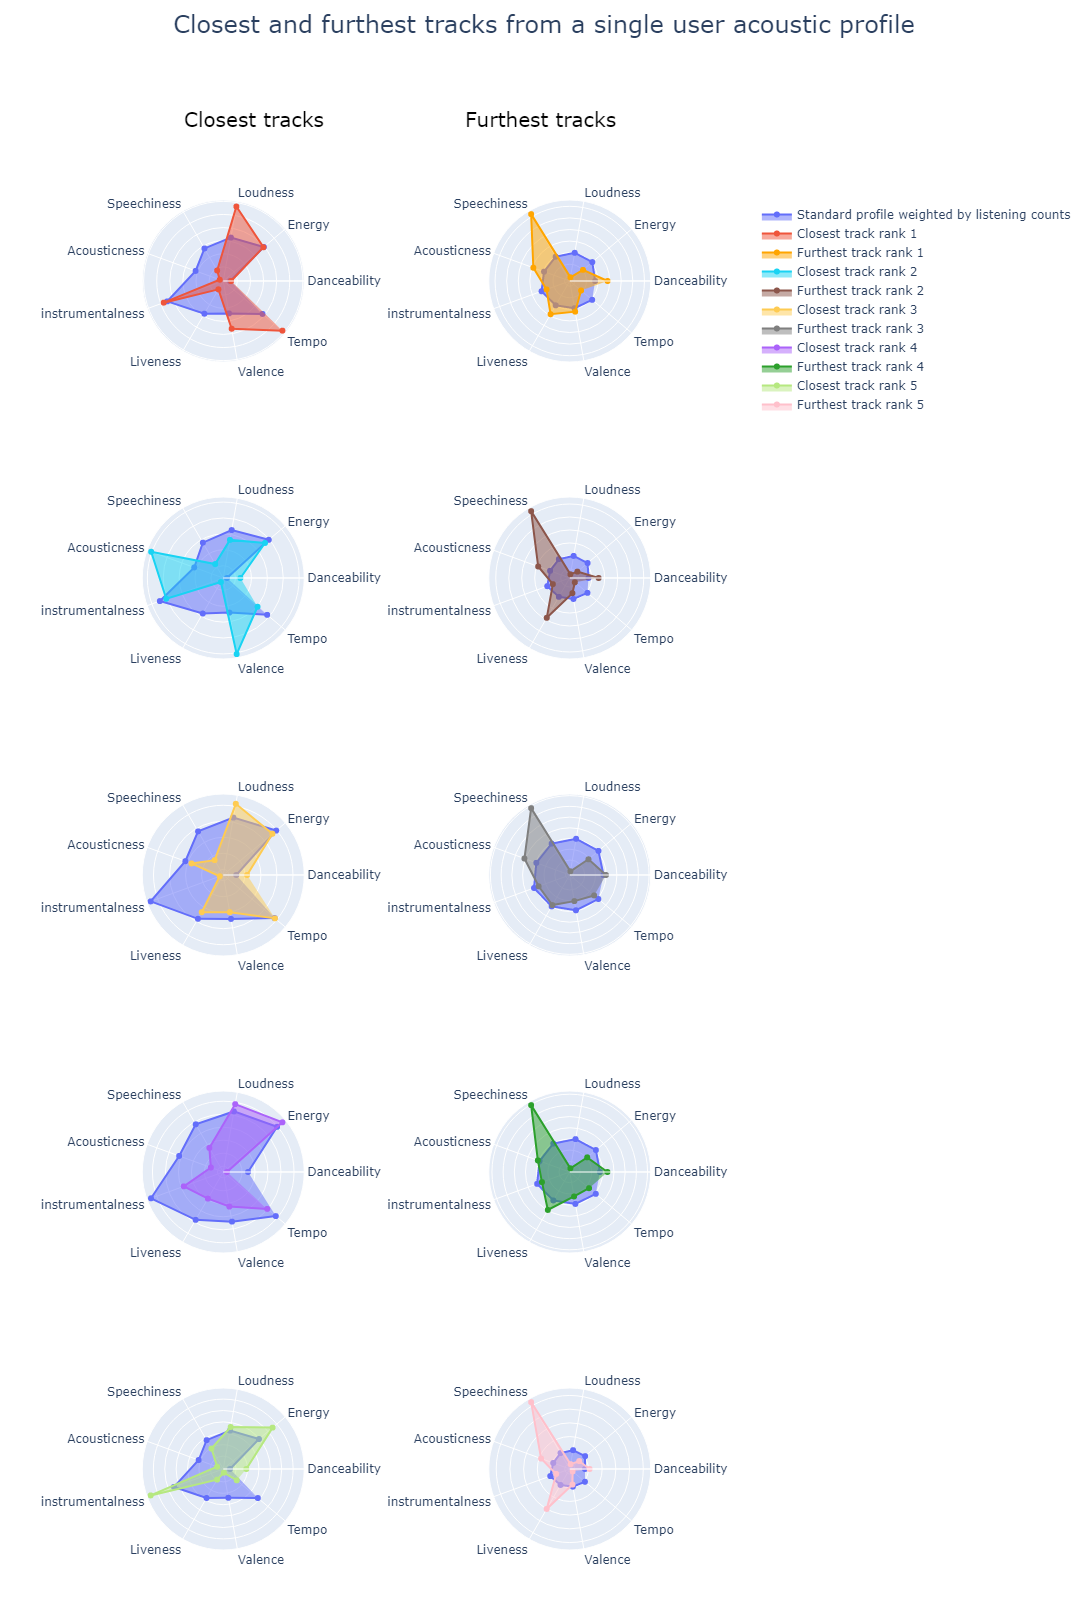

In [850]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


for i in range(len(similar)):

    if (len(similar) == 1):
        profile = standard_profile
        std_prof = True
        prof_name = "Standard profile weighted by listening counts"
        fig_title = f"Closest and furthest tracks from standard profile of user '{user_name}'"
        col1_title = "Closest tracks"
        col2_title = "Furthest tracks"

    elif (len(similar) > 1):
        profile = clusters_profiles    
        std_prof = False
        prof_name = f"Cluster center centroid {i+1} profile" 
        fig_title = f"Closest and furthest tracks from centroid {i+1} profile of user '{user_name}'"
        col1_title = f"Closest tracks from centroid {i+1}"
        col2_title = f"Furthest tracks from centroid {i+1}"

    
    fig = make_subplots(rows=n_neighbors, cols=2,
                        shared_xaxes='columns', shared_yaxes='columns',
                        vertical_spacing = 0.1,
                        horizontal_spacing=0,
                        specs = [[{'type': 'polar'}]*2]*n_neighbors)


    trace_profile = go.Scatterpolar(r = profile[i],
                                             theta = acoustic_variables,
                                             mode = "lines+markers", line_color='#636EFA',
                                             
                                                                                          
                                             name = prof_name)

    #https://community.plotly.com/t/plotly-colours-list/11730/3
    colors_col2 = ['orange', '#8c564b', '#7f7f7f', '#2ca02c', 'pink' ]


    for j in range(len(similar[i])):
        fig.add_trace(trace_profile, row=j+1, col=1)

        fig.add_trace(go.Scatterpolar(
            r = similar[i][j],
            name = f"Closest track rank {j+1}",
            theta = acoustic_variables,
            ), row=j+1, col=1
        )

        fig.add_trace(trace_profile, row=j+1, col=2)

        fig.add_trace(go.Scatterpolar(
            r = disimilar[i][j],
            name = f"Furthest track rank {j+1}",
            theta = acoustic_variables,
            line_color = colors_col2[j]
            ),
            row=j+1, col=2
        )

    fig.add_annotation(x= 0.14, y = 1.07,
                       text = col1_title,
                       showarrow=False,
                       font = dict(color="black",
                                   size=20))


    fig.add_annotation(x= 0.86, y = 1.07,
                       text = col2_title,
                       showarrow=False,
                       font = dict(color="black",
                                   size=20))

    fig.update_traces(fill='toself')

    fig.update_layout(
    height = 1600,
    width = 1600,
    title= dict(text=fig_title,
                x=0.5,
                y=0.99,
                font = dict(
                    size = 24)
                ),
    margin=dict(l=50, r=50, t=200, b=50),
    polar = dict(radialaxis = dict(showticklabels=False, ticks='')), 
    showlegend=True
    )

    #https://plotly.com/python/reference/layout/polar/
    fig.update_polars(
        radialaxis_showticklabels = False
    )
    names = set()
    fig.for_each_trace(
        lambda trace:
            trace.update(showlegend=False)
            if (trace.name in names) else names.add(trace.name))

    fig.show()


## Additional viz on subset of acoustic variables 

In [3]:
# Read the data
CUR_DIR = os.path.abspath('')

DATA_DIR = Path(CUR_DIR).parent / "data"/"millionsong"
FIG_PATH = Path(CUR_DIR).parent/'figures'

FILE_PATH = DATA_DIR/'triplets_metadata_spotify.csv'
df = pd.read_csv(FILE_PATH, index_col = 0)

In [4]:
df['track_id'] = df.song_name + ' - ' + df.artist_name

In [5]:
len(df)

4982520

## Data management

In [6]:
## keep first occurence of a given song/artist instance to reduce redundant observations
df = df.drop_duplicates(subset = ['user','track_id'], keep='first')
len(df)

4973744

In [7]:
df.columns

Index(['user', 'listening_count', 'song_name', 'release', 'artist_name',
       'duration', 'artist_familiarity', 'artist_hotttnesss', 'year',
       'shs_perf', 'shs_work', 'explicit', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature', 'release_date',
       'track_id'],
      dtype='object')

### Songs management

In [8]:
# Get the songs quantitative features

tracks_feats = df.drop(['user', 'listening_count'],axis = 1)
tracks_feats['track_id'] = df.song_name + ' - ' + df.artist_name
tracks_quanti_feats = tracks_feats.drop(['song_name', 'release', 'artist_name',
        'artist_familiarity', 'artist_hotttnesss', 'year', 'key',
       'shs_perf', 'shs_work', 'explicit', 'mode', 'time_signature', 'release_date', 'duration', 'tempo'], axis = 1).drop_duplicates()

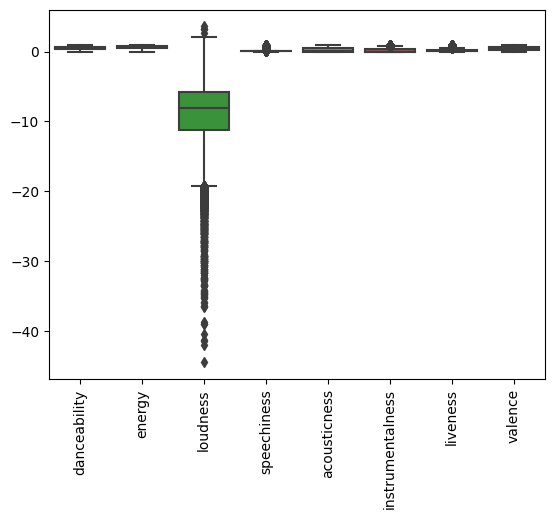

In [9]:
ax = sns.boxplot(tracks_quanti_feats)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);
plt.show()

In [10]:
# Normalize the songs quantitative feats
X = tracks_quanti_feats.drop(['track_id'], axis = 1)
X.index = tracks_quanti_feats.track_id

scaler = StandardScaler()
X[X.columns] = pd.DataFrame(scaler.fit_transform(X), index=X.index)

In [11]:
X

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence
track_id,,,,,,,,
Stronger - Kanye West,0.667073,0.244482,0.234685,0.971940,-0.825165,-0.623569,1.661334,0.055057
Stacked Actors - Foo Fighters,-0.048441,1.150060,0.862181,-0.294877,-0.842482,-0.620462,0.105924,0.728483
Clarity - John Mayer,0.868312,0.283685,1.220943,-0.411504,-0.316887,-0.526080,-0.197701,0.039664
Gimme Stitches - Foo Fighters,0.180747,1.244146,1.071496,-0.108876,-0.843348,-0.614856,0.260399,0.197438
Breakout - Foo Fighters,-0.501227,1.165741,1.072171,-0.272758,-0.848599,-0.614704,-0.480018,-0.206617
...,...,...,...,...,...,...,...,...
Dime - Jerry Rivera,0.991291,-0.429800,-0.219056,-0.392401,1.575591,-0.623569,0.015369,1.247983
The Long Conversation - Pierre de Reeder,-0.395018,-1.370660,-0.236161,-0.523105,1.705467,-0.520901,0.825034,-1.007032
That's the Way That It Was - Pierre de Reeder,0.583224,0.228801,0.703957,-0.425580,-0.754445,-0.623329,-0.543939,-0.679940


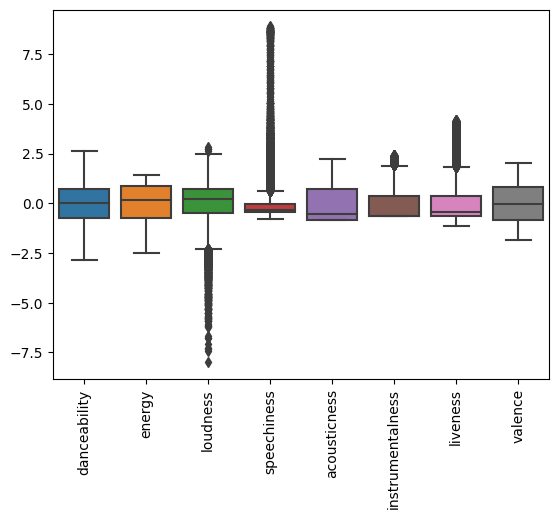

In [12]:
ax = sns.boxplot(X)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);
plt.savefig(FIG_PATH/f'Data_viz/audio_features_boxplot.jpg')
plt.show()

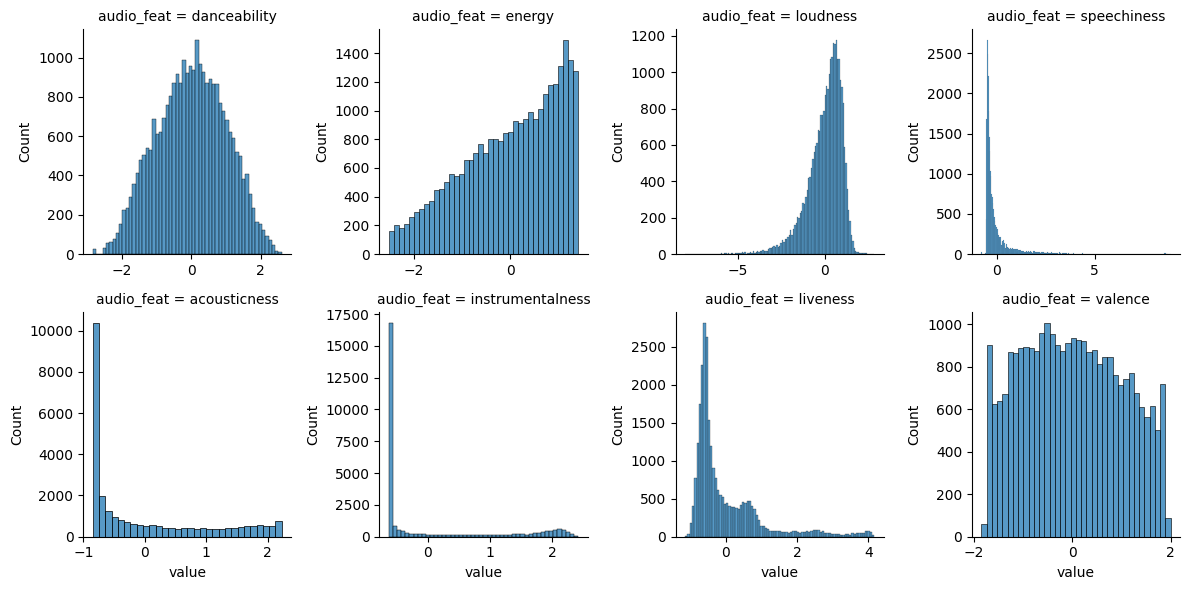

In [13]:
g = sns.FacetGrid(X.melt(var_name = 'audio_feat', value_name = 'value'), col = 'audio_feat', col_wrap = 4, sharey = False, sharex = False)
g.map(sns.histplot, 'value')
plt.savefig(FIG_PATH/f'Data_viz/audio_features_distribution.jpg')
plt.show()

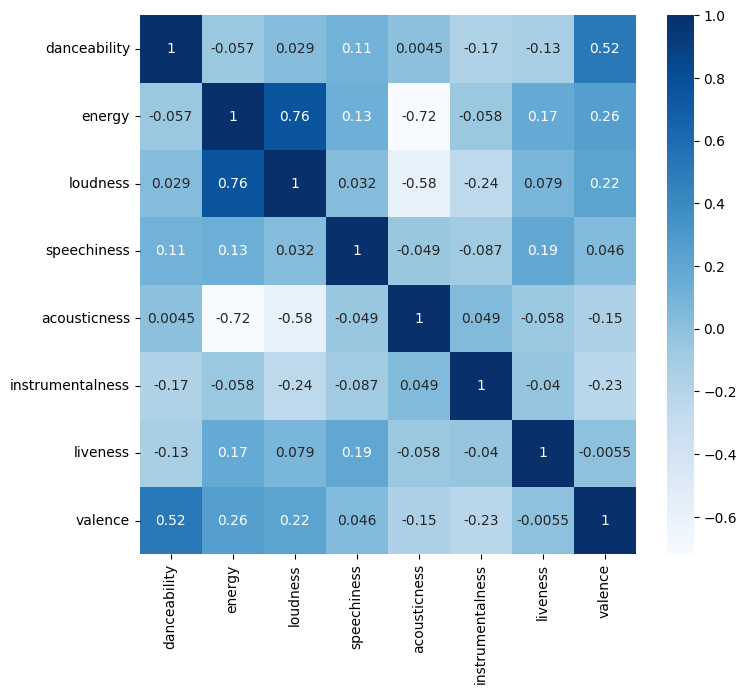

In [14]:
corr = X.corr()
plt.figure(figsize =(8,7))
sns.heatmap(corr, cmap="Blues", annot=True)
plt.savefig(FIG_PATH/f'Data_viz/audio_features_corr_tracks.jpg')
plt.show()